In [30]:
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn.parallel import DataParallel
from torch.optim.lr_scheduler import MultiStepLR
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import OrderedDict
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os
from torch.utils.data import DataLoader, TensorDataset
import pickle
from collections import Counter


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

import torch
print(torch.cuda.device_count())

1


In [6]:
# Define CIFAR dataset transformations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance of flipping
    transforms.Pad(4),  # Zero-padding to 40x40
    transforms.RandomCrop(32),  # Randomly crop back to 32x32
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    # transforms.ToDtype(torch.float32, scale=True),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

# Define CIFAR test dataset transformations (no data augmentation)
val_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

batch_size = 128
trainset = torchvision.datasets.CIFAR10(root='/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/', train=True, download=False, transform=train_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valset = torchvision.datasets.CIFAR10(root='/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/', train=False, download=False, transform=val_transform)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)

combined_trainset = torch.utils.data.ConcatDataset([trainset, valset])
combined_train_loader = torch.utils.data.DataLoader(
    combined_trainset, 
    batch_size=batch_size,
    shuffle=True, 
    num_workers=2
)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

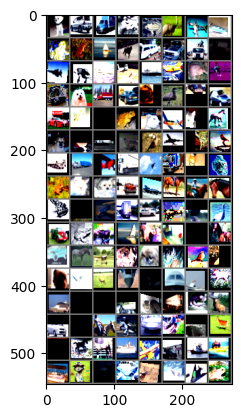

dog   car   truck frog  frog  bird  plane ship  frog  frog  ship  horse car   car   truck deer  plane plane plane dog   ship  plane bird  deer  truck dog   truck car   frog  bird  truck car   car   bird  dog   frog  dog   plane cat   horse dog   dog   truck frog  bird  plane frog  bird  truck truck plane truck plane truck bird  frog  frog  cat   dog   ship  plane horse horse horse frog  truck plane truck car   plane horse bird  truck frog  deer  ship  horse cat   dog   horse car   horse plane frog  dog   deer  bird  frog  dog   plane deer  plane horse plane ship  dog   ship  cat   ship  horse cat   truck frog  deer  car   cat   horse horse car   truck ship  deer  truck horse horse ship  plane truck ship  ship  ship  bird  ship  plane deer  deer  plane frog 


In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [8]:
def initialize_weights(module):
    if isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight.data, mode='fan_out')
    elif isinstance(module, nn.BatchNorm2d):
        module.weight.data.fill_(1)
        module.bias.data.zero_()
    elif isinstance(module, nn.Linear):
        module.bias.data.zero_()

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                     bias=False)

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.conv1 = conv1x1(inplanes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn3 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn4 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.bn1(x)
        out = self.conv1(out)
        
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)
        
        out = self.bn4(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity

        return out

class PyramidNet(nn.Module):
    def __init__(self, config):
        super(PyramidNet, self).__init__()
        
        input_shape = config['input_shape']
        n_classes = config['n_classes']
        depth = config['depth']
        alpha = config['alpha']
        
        # PyramidNet params
        block = Bottleneck
        self.inplanes = 16
        n = (depth - 2) // 9  # Bottleneck: (depth-2)/9
        
        # Calculate widening factor
        self.start_channel = 16
        self.addrate = alpha / (3 * n)
        
        # Initial convolution
        self.conv1 = nn.Conv2d(input_shape[1], 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        
        # Build pyramid blocks
        current_channel = self.start_channel
        self.layer1 = self._make_layer(block, current_channel, n, stride=1)
        current_channel += self.addrate * n
        self.layer2 = self._make_layer(block, current_channel, n, stride=2)
        current_channel += self.addrate * n
        self.layer3 = self._make_layer(block, current_channel, n, stride=2)
        
        # Final batch norm and classifier
        self.bn_final = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(self.inplanes, n_classes)
        
        # Initialize weights
        self.apply(initialize_weights)

    def _make_layer(self, block, start_planes, blocks, stride=1):
        downsample = None
        end_planes = start_planes + self.addrate * (blocks - 1)
        planes = int(round(start_planes))
        
        if stride != 1 or self.inplanes != planes * block.expansion:
            if stride == 2:
                downsample = nn.Sequential(
                    nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(self.inplanes, planes * block.expansion, 
                              kernel_size=1, stride=1, padding=0, bias=False)
                    if self.inplanes != planes * block.expansion else nn.Identity()
                )
            else:
                downsample = nn.Sequential(
                    nn.Conv2d(self.inplanes, planes * block.expansion,
                             kernel_size=1, stride=stride, padding=0, bias=False)
                    if self.inplanes != planes * block.expansion else nn.Identity()
                )
                
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        
        # Create rest of the blocks with gradually increasing width
        for i in range(1, blocks):
            current_planes = start_planes + self.addrate * i
            planes = int(round(current_planes))
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                         kernel_size=1, stride=1, padding=0, bias=False)
            ) if self.inplanes != planes * block.expansion else None
            
            layers.append(block(self.inplanes, planes, 1, downsample))
            self.inplanes = planes * block.expansion
            
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = self.bn_final(x)
        x = self.relu(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x

In [15]:
model_config = OrderedDict([
    ('arch', 'pyramid_net'),
    ('depth', 26),  
    ('base_channels', 16),  # Starting channels
    ('alpha', 300),  # Total widening factor
    ('input_shape', (1, 3, 32, 32)),
    ('n_classes', 10),
])

model = PyramidNet(model_config).to(device)

# Calculate Total Parameters and Number of Layers
def val(net):
    import numpy as np
    total_params = 0

    for x in filter(lambda p: p.requires_grad, net.parameters()):
        total_params += np.prod(x.cpu().data.numpy().shape)
    print("Total Number of Parameters: ", total_params)
    print("Total Layers of Parameters: ", len(list(filter(lambda p: p.requires_grad and len(p.data.size())>1, net.parameters()))))

val(model)

Total Number of Parameters:  4574414
Total Layers of Parameters:  26


In [20]:
# Hyperparameters
num_epochs = 150
learning_rate = 0.1

# Device configuration (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)

# Learning rate scheduler (decay at 90 and 135 epochs)
scheduler = MultiStepLR(optimizer, milestones=[90, 135], gamma=0.1)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

def train(epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Compute average training loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    scheduler.step()  # Update learning rate

def val(epoch):
    model.eval()
    running_loss_val = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss_val += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Compute average validation loss and accuracy
    epoch_loss = running_loss_val / len(val_loader)
    epoch_acc = 100 * correct / total
    val_losses.append(epoch_loss)
    val_accuracies.append(epoch_acc)

# Training loop with clear epoch-wise output
print("\nEpoch | Train Loss | Train Acc | Val Loss | Val Acc")
print("-" * 50)
for epoch in tqdm(range(num_epochs)):
    train(epoch)
    val(epoch)
    print(f"{epoch+1:5d} | {train_losses[-1]:.4f}  | {train_accuracies[-1]:.2f}%   | {val_losses[-1]:.4f}  | {val_accuracies[-1]:.2f}%")



Epoch | Train Loss | Train Acc | Val Loss | Val Acc
--------------------------------------------------


  1%|          | 1/150 [00:54<2:15:17, 54.48s/it]

    1 | 1.9678  | 28.82%   | 1.6233  | 40.47%


  1%|▏         | 2/150 [01:47<2:12:43, 53.81s/it]

    2 | 1.4875  | 46.11%   | 1.2708  | 54.73%


  2%|▏         | 3/150 [02:41<2:11:28, 53.66s/it]

    3 | 1.2634  | 54.86%   | 1.1161  | 60.92%


  3%|▎         | 4/150 [03:34<2:10:14, 53.52s/it]

    4 | 1.1275  | 60.00%   | 0.9180  | 67.60%


  3%|▎         | 5/150 [04:27<2:09:09, 53.45s/it]

    5 | 1.0238  | 63.85%   | 0.9077  | 68.81%


  4%|▍         | 6/150 [05:21<2:08:09, 53.40s/it]

    6 | 0.9230  | 68.00%   | 1.0073  | 68.55%


  5%|▍         | 7/150 [06:14<2:07:15, 53.39s/it]

    7 | 0.8588  | 70.19%   | 0.8578  | 73.23%


  5%|▌         | 8/150 [07:07<2:06:19, 53.38s/it]

    8 | 0.8010  | 72.38%   | 0.7754  | 75.31%


  6%|▌         | 9/150 [08:01<2:05:23, 53.36s/it]

    9 | 0.7627  | 73.47%   | 0.6690  | 77.40%


  7%|▋         | 10/150 [08:54<2:04:28, 53.35s/it]

   10 | 0.7277  | 74.78%   | 0.6358  | 77.89%


  7%|▋         | 11/150 [09:47<2:03:34, 53.34s/it]

   11 | 0.7061  | 75.73%   | 0.7837  | 74.07%


  8%|▊         | 12/150 [10:41<2:02:41, 53.34s/it]

   12 | 0.6791  | 76.46%   | 0.5855  | 80.23%


  9%|▊         | 13/150 [11:34<2:01:49, 53.35s/it]

   13 | 0.6618  | 77.07%   | 0.5673  | 81.46%


  9%|▉         | 14/150 [12:27<2:00:55, 53.35s/it]

   14 | 0.6375  | 77.83%   | 0.5288  | 82.56%


 10%|█         | 15/150 [13:21<2:00:01, 53.34s/it]

   15 | 0.6276  | 78.36%   | 0.5568  | 80.98%


 11%|█         | 16/150 [14:14<1:59:05, 53.33s/it]

   16 | 0.6058  | 78.94%   | 0.7980  | 75.75%


 11%|█▏        | 17/150 [15:07<1:58:12, 53.33s/it]

   17 | 0.5997  | 79.20%   | 0.5261  | 82.61%


 12%|█▏        | 18/150 [16:01<1:57:24, 53.37s/it]

   18 | 0.5841  | 79.84%   | 0.6051  | 80.61%


 13%|█▎        | 19/150 [16:54<1:56:33, 53.39s/it]

   19 | 0.5695  | 80.37%   | 0.4584  | 84.93%


 13%|█▎        | 20/150 [17:48<1:55:42, 53.40s/it]

   20 | 0.5744  | 80.26%   | 0.7487  | 78.13%


 14%|█▍        | 21/150 [18:41<1:54:50, 53.42s/it]

   21 | 0.5689  | 80.32%   | 0.4680  | 83.90%


 15%|█▍        | 22/150 [19:35<1:53:59, 53.44s/it]

   22 | 0.5571  | 80.73%   | 0.5258  | 82.22%


 15%|█▌        | 23/150 [20:28<1:53:06, 53.43s/it]

   23 | 0.5503  | 80.92%   | 0.5221  | 83.05%


 16%|█▌        | 24/150 [21:22<1:52:14, 53.45s/it]

   24 | 0.5356  | 81.52%   | 0.5115  | 83.35%


 17%|█▋        | 25/150 [22:15<1:51:14, 53.39s/it]

   25 | 0.5379  | 81.35%   | 0.5387  | 81.93%


 17%|█▋        | 26/150 [23:08<1:50:18, 53.37s/it]

   26 | 0.5277  | 81.66%   | 0.5269  | 81.88%


 18%|█▊        | 27/150 [24:02<1:49:31, 53.43s/it]

   27 | 0.5207  | 82.05%   | 0.5329  | 82.76%


 19%|█▊        | 28/150 [24:55<1:48:38, 53.43s/it]

   28 | 0.5124  | 82.17%   | 0.4993  | 83.54%


 19%|█▉        | 29/150 [25:49<1:47:45, 53.43s/it]

   29 | 0.5096  | 82.52%   | 0.4750  | 84.26%


 20%|██        | 30/150 [26:42<1:46:52, 53.44s/it]

   30 | 0.5175  | 82.05%   | 0.4279  | 85.64%


 21%|██        | 31/150 [27:35<1:45:58, 53.43s/it]

   31 | 0.5052  | 82.54%   | 0.5475  | 82.31%


 21%|██▏       | 32/150 [28:29<1:45:05, 53.44s/it]

   32 | 0.5056  | 82.44%   | 0.4907  | 83.34%


 22%|██▏       | 33/150 [29:22<1:44:13, 53.45s/it]

   33 | 0.4973  | 82.96%   | 0.6099  | 81.88%


 23%|██▎       | 34/150 [30:16<1:43:19, 53.44s/it]

   34 | 0.4968  | 82.81%   | 0.7326  | 78.54%


 23%|██▎       | 35/150 [31:09<1:42:27, 53.46s/it]

   35 | 0.4988  | 82.67%   | 0.5273  | 82.91%


 24%|██▍       | 36/150 [32:03<1:41:34, 53.46s/it]

   36 | 0.4881  | 83.03%   | 0.4278  | 85.49%


 25%|██▍       | 37/150 [32:56<1:40:39, 53.45s/it]

   37 | 0.4931  | 82.86%   | 0.3931  | 86.34%


 25%|██▌       | 38/150 [33:50<1:39:45, 53.44s/it]

   38 | 0.4876  | 83.02%   | 0.4399  | 86.01%


 26%|██▌       | 39/150 [34:43<1:38:51, 53.44s/it]

   39 | 0.4883  | 83.03%   | 0.3736  | 87.51%


 27%|██▋       | 40/150 [35:36<1:37:56, 53.43s/it]

   40 | 0.4760  | 83.55%   | 0.4798  | 84.39%


 27%|██▋       | 41/150 [36:30<1:37:04, 53.44s/it]

   41 | 0.4770  | 83.47%   | 0.4320  | 85.49%


 28%|██▊       | 42/150 [37:23<1:36:10, 53.43s/it]

   42 | 0.4752  | 83.62%   | 0.4100  | 86.60%


 29%|██▊       | 43/150 [38:17<1:35:19, 53.46s/it]

   43 | 0.4775  | 83.32%   | 0.4273  | 85.89%


 29%|██▉       | 44/150 [39:10<1:34:28, 53.48s/it]

   44 | 0.4699  | 83.70%   | 0.5101  | 83.39%


 30%|███       | 45/150 [40:04<1:33:35, 53.48s/it]

   45 | 0.4691  | 83.72%   | 0.4651  | 84.32%


 31%|███       | 46/150 [40:57<1:32:38, 53.45s/it]

   46 | 0.4629  | 83.96%   | 0.6752  | 80.09%


 31%|███▏      | 47/150 [41:51<1:31:44, 53.44s/it]

   47 | 0.4661  | 83.97%   | 0.4554  | 85.02%


 32%|███▏      | 48/150 [42:44<1:30:49, 53.42s/it]

   48 | 0.4599  | 84.13%   | 0.4045  | 86.73%


 33%|███▎      | 49/150 [43:38<1:29:56, 53.43s/it]

   49 | 0.4640  | 83.93%   | 0.3763  | 87.65%


 33%|███▎      | 50/150 [44:31<1:29:02, 53.43s/it]

   50 | 0.4658  | 83.92%   | 0.4229  | 85.63%


 34%|███▍      | 51/150 [45:24<1:28:10, 53.44s/it]

   51 | 0.4674  | 83.86%   | 0.5144  | 82.92%


 35%|███▍      | 52/150 [46:18<1:27:18, 53.46s/it]

   52 | 0.4593  | 84.13%   | 0.4101  | 86.25%


 35%|███▌      | 53/150 [47:11<1:26:27, 53.48s/it]

   53 | 0.4551  | 84.09%   | 0.4872  | 84.43%


 36%|███▌      | 54/150 [48:05<1:25:35, 53.49s/it]

   54 | 0.4522  | 84.35%   | 0.4414  | 86.29%


 37%|███▋      | 55/150 [48:58<1:24:41, 53.49s/it]

   55 | 0.4499  | 84.44%   | 0.3881  | 87.41%


 37%|███▋      | 56/150 [49:52<1:23:49, 53.50s/it]

   56 | 0.4517  | 84.34%   | 0.3818  | 87.60%


 38%|███▊      | 57/150 [50:45<1:22:52, 53.47s/it]

   57 | 0.4432  | 84.72%   | 0.4406  | 85.26%


 39%|███▊      | 58/150 [51:39<1:21:57, 53.46s/it]

   58 | 0.4484  | 84.41%   | 0.4056  | 86.84%


 39%|███▉      | 59/150 [52:32<1:21:04, 53.45s/it]

   59 | 0.4461  | 84.54%   | 0.4032  | 86.65%


 40%|████      | 60/150 [53:26<1:20:11, 53.46s/it]

   60 | 0.4464  | 84.49%   | 0.4221  | 86.57%


 41%|████      | 61/150 [54:19<1:19:17, 53.45s/it]

   61 | 0.4421  | 84.88%   | 0.4498  | 85.36%


 41%|████▏     | 62/150 [55:13<1:18:24, 53.46s/it]

   62 | 0.4518  | 84.42%   | 0.6781  | 79.26%


 42%|████▏     | 63/150 [56:06<1:17:29, 53.44s/it]

   63 | 0.4434  | 84.66%   | 0.4177  | 86.39%


 43%|████▎     | 64/150 [56:59<1:16:34, 53.43s/it]

   64 | 0.4360  | 84.87%   | 0.4213  | 86.51%


 43%|████▎     | 65/150 [57:53<1:15:39, 53.41s/it]

   65 | 0.4493  | 84.35%   | 0.4304  | 86.31%


 44%|████▍     | 66/150 [58:46<1:14:46, 53.41s/it]

   66 | 0.4401  | 84.64%   | 0.4384  | 85.88%


 45%|████▍     | 67/150 [59:40<1:13:54, 53.43s/it]

   67 | 0.4308  | 85.06%   | 0.5734  | 81.32%


 45%|████▌     | 68/150 [1:00:33<1:12:59, 53.41s/it]

   68 | 0.4402  | 84.78%   | 0.4611  | 85.34%


 46%|████▌     | 69/150 [1:01:26<1:12:05, 53.40s/it]

   69 | 0.4368  | 84.82%   | 0.4208  | 86.25%


 47%|████▋     | 70/150 [1:02:20<1:11:13, 53.42s/it]

   70 | 0.4356  | 84.86%   | 0.4122  | 86.21%


 47%|████▋     | 71/150 [1:03:13<1:10:20, 53.42s/it]

   71 | 0.4361  | 84.97%   | 0.5540  | 83.23%


 48%|████▊     | 72/150 [1:04:07<1:09:26, 53.41s/it]

   72 | 0.4341  | 84.99%   | 0.4725  | 84.67%


 49%|████▊     | 73/150 [1:05:00<1:08:32, 53.41s/it]

   73 | 0.4311  | 85.08%   | 0.4578  | 85.61%


 49%|████▉     | 74/150 [1:05:53<1:07:37, 53.39s/it]

   74 | 0.4240  | 85.27%   | 0.4353  | 86.12%


 50%|█████     | 75/150 [1:06:47<1:06:43, 53.38s/it]

   75 | 0.4348  | 84.98%   | 0.4295  | 86.15%


 51%|█████     | 76/150 [1:07:40<1:05:49, 53.38s/it]

   76 | 0.4316  | 85.01%   | 0.4078  | 87.17%


 51%|█████▏    | 77/150 [1:08:34<1:04:57, 53.40s/it]

   77 | 0.4314  | 85.11%   | 0.4150  | 86.40%


 52%|█████▏    | 78/150 [1:09:27<1:04:05, 53.41s/it]

   78 | 0.4271  | 85.15%   | 0.4801  | 84.60%


 53%|█████▎    | 79/150 [1:10:20<1:03:12, 53.41s/it]

   79 | 0.4335  | 84.91%   | 0.3807  | 87.97%


 53%|█████▎    | 80/150 [1:11:14<1:02:17, 53.39s/it]

   80 | 0.4318  | 84.95%   | 0.3884  | 87.38%


 54%|█████▍    | 81/150 [1:12:07<1:01:23, 53.38s/it]

   81 | 0.4252  | 85.30%   | 0.3899  | 87.33%


 55%|█████▍    | 82/150 [1:13:01<1:00:29, 53.37s/it]

   82 | 0.4253  | 85.23%   | 0.3780  | 87.72%


 55%|█████▌    | 83/150 [1:13:54<59:36, 53.38s/it]  

   83 | 0.4219  | 85.56%   | 0.4416  | 85.76%


 56%|█████▌    | 84/150 [1:14:47<58:42, 53.38s/it]

   84 | 0.4251  | 85.21%   | 0.4325  | 86.36%


 57%|█████▋    | 85/150 [1:15:41<57:49, 53.37s/it]

   85 | 0.4228  | 85.18%   | 0.3980  | 86.92%


 57%|█████▋    | 86/150 [1:16:34<56:55, 53.37s/it]

   86 | 0.4201  | 85.39%   | 0.4564  | 85.54%


 58%|█████▊    | 87/150 [1:17:27<56:01, 53.35s/it]

   87 | 0.4151  | 85.52%   | 0.4720  | 84.43%


 59%|█████▊    | 88/150 [1:18:21<55:09, 53.39s/it]

   88 | 0.4241  | 85.38%   | 0.4264  | 86.14%


 59%|█████▉    | 89/150 [1:19:14<54:16, 53.39s/it]

   89 | 0.4235  | 85.32%   | 0.5861  | 81.14%


 60%|██████    | 90/150 [1:20:08<53:23, 53.39s/it]

   90 | 0.4268  | 85.33%   | 0.4186  | 86.83%


 61%|██████    | 91/150 [1:21:01<52:29, 53.38s/it]

   91 | 0.2974  | 89.76%   | 0.2184  | 92.71%


 61%|██████▏   | 92/150 [1:21:54<51:35, 53.37s/it]

   92 | 0.2499  | 91.32%   | 0.2192  | 92.73%


 62%|██████▏   | 93/150 [1:22:48<50:41, 53.35s/it]

   93 | 0.2359  | 91.89%   | 0.2080  | 93.10%


 63%|██████▎   | 94/150 [1:23:41<49:46, 53.34s/it]

   94 | 0.2302  | 92.25%   | 0.2092  | 93.35%


 63%|██████▎   | 95/150 [1:24:34<48:52, 53.32s/it]

   95 | 0.2237  | 92.31%   | 0.2063  | 93.26%


 64%|██████▍   | 96/150 [1:25:27<47:58, 53.30s/it]

   96 | 0.2134  | 92.68%   | 0.2058  | 93.36%


 65%|██████▍   | 97/150 [1:26:21<47:04, 53.29s/it]

   97 | 0.2087  | 92.80%   | 0.2031  | 93.29%


 65%|██████▌   | 98/150 [1:27:14<46:10, 53.29s/it]

   98 | 0.2084  | 92.94%   | 0.2130  | 93.39%


 66%|██████▌   | 99/150 [1:28:07<45:17, 53.28s/it]

   99 | 0.2011  | 93.04%   | 0.2065  | 93.40%


 67%|██████▋   | 100/150 [1:29:00<44:23, 53.27s/it]

  100 | 0.2000  | 93.17%   | 0.2018  | 93.82%


 67%|██████▋   | 101/150 [1:29:54<43:30, 53.28s/it]

  101 | 0.1960  | 93.32%   | 0.2154  | 93.33%


 68%|██████▊   | 102/150 [1:30:47<42:38, 53.31s/it]

  102 | 0.1913  | 93.45%   | 0.2068  | 93.55%


 69%|██████▊   | 103/150 [1:31:41<41:46, 53.33s/it]

  103 | 0.1897  | 93.45%   | 0.2058  | 93.75%


 69%|██████▉   | 104/150 [1:32:34<40:53, 53.33s/it]

  104 | 0.1907  | 93.29%   | 0.2137  | 93.43%


 70%|███████   | 105/150 [1:33:27<39:59, 53.33s/it]

  105 | 0.1873  | 93.56%   | 0.1999  | 93.78%


 71%|███████   | 106/150 [1:34:21<39:06, 53.33s/it]

  106 | 0.1829  | 93.71%   | 0.2043  | 93.70%


 71%|███████▏  | 107/150 [1:35:14<38:14, 53.35s/it]

  107 | 0.1824  | 93.66%   | 0.2151  | 93.59%


 72%|███████▏  | 108/150 [1:36:07<37:20, 53.36s/it]

  108 | 0.1812  | 93.76%   | 0.2051  | 93.73%


 73%|███████▎  | 109/150 [1:37:01<36:27, 53.35s/it]

  109 | 0.1794  | 93.86%   | 0.2110  | 93.56%


 73%|███████▎  | 110/150 [1:37:54<35:33, 53.34s/it]

  110 | 0.1817  | 93.66%   | 0.2011  | 93.93%


 74%|███████▍  | 111/150 [1:38:47<34:40, 53.34s/it]

  111 | 0.1765  | 93.93%   | 0.2070  | 93.96%


 75%|███████▍  | 112/150 [1:39:41<33:46, 53.32s/it]

  112 | 0.1728  | 94.16%   | 0.2176  | 93.51%


 75%|███████▌  | 113/150 [1:40:34<32:52, 53.32s/it]

  113 | 0.1707  | 94.20%   | 0.2111  | 93.58%


 76%|███████▌  | 114/150 [1:41:27<31:59, 53.32s/it]

  114 | 0.1730  | 93.97%   | 0.2042  | 93.88%


 77%|███████▋  | 115/150 [1:42:21<31:06, 53.33s/it]

  115 | 0.1681  | 94.13%   | 0.2236  | 93.44%


 77%|███████▋  | 116/150 [1:43:14<30:14, 53.38s/it]

  116 | 0.1697  | 94.14%   | 0.2058  | 94.02%


 78%|███████▊  | 117/150 [1:44:07<29:21, 53.37s/it]

  117 | 0.1685  | 94.24%   | 0.2131  | 93.85%


 79%|███████▊  | 118/150 [1:45:01<28:27, 53.36s/it]

  118 | 0.1662  | 94.33%   | 0.2178  | 93.72%


 79%|███████▉  | 119/150 [1:45:54<27:34, 53.37s/it]

  119 | 0.1682  | 94.26%   | 0.2090  | 93.90%


 80%|████████  | 120/150 [1:46:47<26:40, 53.36s/it]

  120 | 0.1657  | 94.22%   | 0.2111  | 93.82%


 81%|████████  | 121/150 [1:47:41<25:46, 53.34s/it]

  121 | 0.1663  | 94.26%   | 0.2139  | 93.59%


 81%|████████▏ | 122/150 [1:48:34<24:53, 53.34s/it]

  122 | 0.1646  | 94.39%   | 0.2184  | 93.71%


 82%|████████▏ | 123/150 [1:49:27<24:00, 53.33s/it]

  123 | 0.1620  | 94.38%   | 0.2101  | 93.73%


 83%|████████▎ | 124/150 [1:50:21<23:07, 53.36s/it]

  124 | 0.1615  | 94.43%   | 0.2212  | 93.63%


 83%|████████▎ | 125/150 [1:51:14<22:14, 53.38s/it]

  125 | 0.1628  | 94.51%   | 0.2157  | 93.74%


 84%|████████▍ | 126/150 [1:52:08<21:21, 53.40s/it]

  126 | 0.1590  | 94.49%   | 0.2243  | 93.59%


 85%|████████▍ | 127/150 [1:53:01<20:27, 53.39s/it]

  127 | 0.1598  | 94.46%   | 0.2149  | 93.84%


 85%|████████▌ | 128/150 [1:53:55<19:34, 53.41s/it]

  128 | 0.1581  | 94.49%   | 0.2138  | 93.85%


 86%|████████▌ | 129/150 [1:54:48<18:41, 53.40s/it]

  129 | 0.1591  | 94.55%   | 0.2062  | 94.02%


 87%|████████▋ | 130/150 [1:55:41<17:47, 53.38s/it]

  130 | 0.1568  | 94.66%   | 0.2182  | 93.62%


 87%|████████▋ | 131/150 [1:56:35<16:54, 53.41s/it]

  131 | 0.1566  | 94.59%   | 0.2143  | 93.77%


 88%|████████▊ | 132/150 [1:57:28<16:01, 53.40s/it]

  132 | 0.1565  | 94.67%   | 0.2381  | 93.12%


 89%|████████▊ | 133/150 [1:58:21<15:07, 53.39s/it]

  133 | 0.1567  | 94.65%   | 0.2320  | 93.56%


 89%|████████▉ | 134/150 [1:59:15<14:13, 53.36s/it]

  134 | 0.1579  | 94.59%   | 0.2230  | 93.73%


 90%|█████████ | 135/150 [2:00:08<13:20, 53.35s/it]

  135 | 0.1493  | 94.79%   | 0.2178  | 94.00%


 91%|█████████ | 136/150 [2:01:01<12:26, 53.35s/it]

  136 | 0.1418  | 95.17%   | 0.2052  | 94.33%


 91%|█████████▏| 137/150 [2:01:55<11:33, 53.38s/it]

  137 | 0.1384  | 95.35%   | 0.2039  | 94.12%


 92%|█████████▏| 138/150 [2:02:48<10:40, 53.37s/it]

  138 | 0.1374  | 95.27%   | 0.2050  | 94.24%


 93%|█████████▎| 139/150 [2:03:42<09:47, 53.39s/it]

  139 | 0.1343  | 95.43%   | 0.2038  | 94.21%


 93%|█████████▎| 140/150 [2:04:35<08:53, 53.38s/it]

  140 | 0.1318  | 95.58%   | 0.2032  | 94.29%


 94%|█████████▍| 141/150 [2:05:28<08:00, 53.37s/it]

  141 | 0.1316  | 95.60%   | 0.2020  | 94.30%


 95%|█████████▍| 142/150 [2:06:22<07:06, 53.36s/it]

  142 | 0.1287  | 95.53%   | 0.2027  | 94.35%


 95%|█████████▌| 143/150 [2:07:15<06:13, 53.36s/it]

  143 | 0.1325  | 95.56%   | 0.2020  | 94.25%


 96%|█████████▌| 144/150 [2:08:08<05:20, 53.38s/it]

  144 | 0.1307  | 95.62%   | 0.2014  | 94.34%


 97%|█████████▋| 145/150 [2:09:02<04:26, 53.39s/it]

  145 | 0.1285  | 95.66%   | 0.2001  | 94.32%


 97%|█████████▋| 146/150 [2:09:55<03:33, 53.42s/it]

  146 | 0.1296  | 95.59%   | 0.2023  | 94.28%


 98%|█████████▊| 147/150 [2:10:49<02:40, 53.41s/it]

  147 | 0.1320  | 95.57%   | 0.2039  | 94.36%


 99%|█████████▊| 148/150 [2:11:42<01:46, 53.43s/it]

  148 | 0.1322  | 95.52%   | 0.2029  | 94.36%


 99%|█████████▉| 149/150 [2:12:36<00:53, 53.44s/it]

  149 | 0.1282  | 95.69%   | 0.2041  | 94.34%


100%|██████████| 150/150 [2:13:29<00:00, 53.40s/it]

  150 | 0.1249  | 95.83%   | 0.2032  | 94.32%


In [40]:
# Find the best validation accuracy and the corresponding epoch
best_val_acc = max(val_accuracies)
best_epoch = val_accuracies.index(best_val_acc) + 1  # +1 to match epoch numbering

print("\n" + "="*50)
print(f"Best Validation Accuracy: {best_val_acc:.2f}% at Epoch {best_epoch}")
print("="*50)


Best Validation Accuracy: 94.36% at Epoch 147


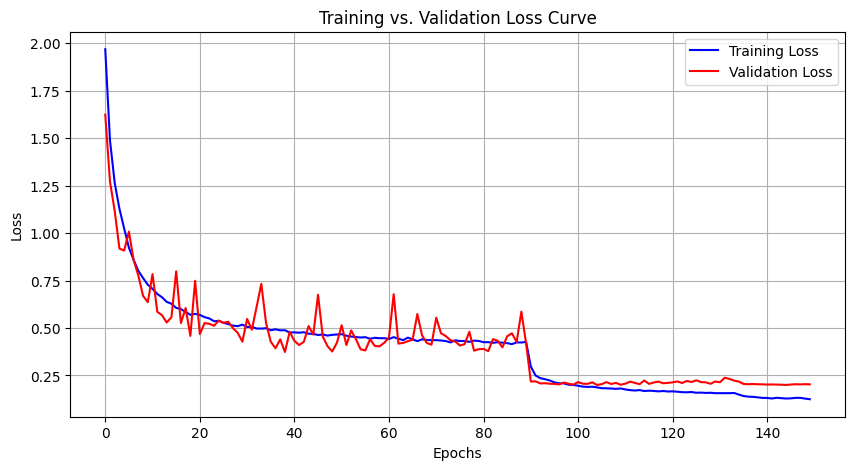

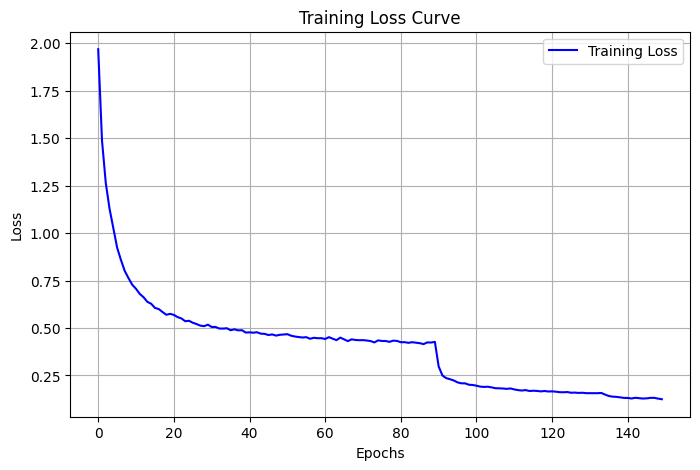

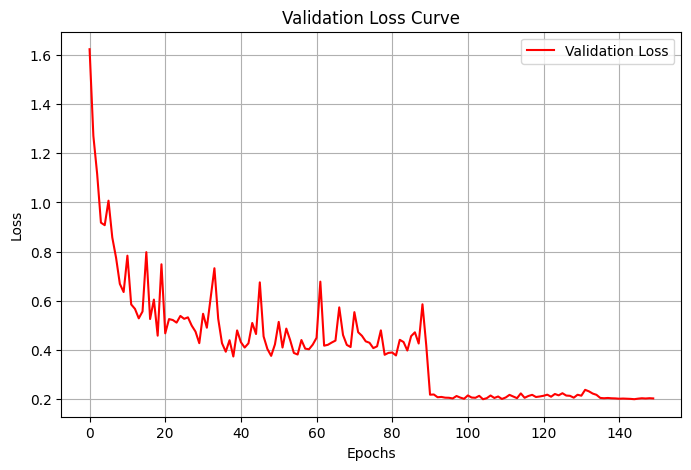

In [31]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, 'b-', label="Training Loss")
plt.plot(val_losses, 'r-', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

# Plot Training Loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, 'b-', label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

# Plot Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(val_losses, 'r-', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

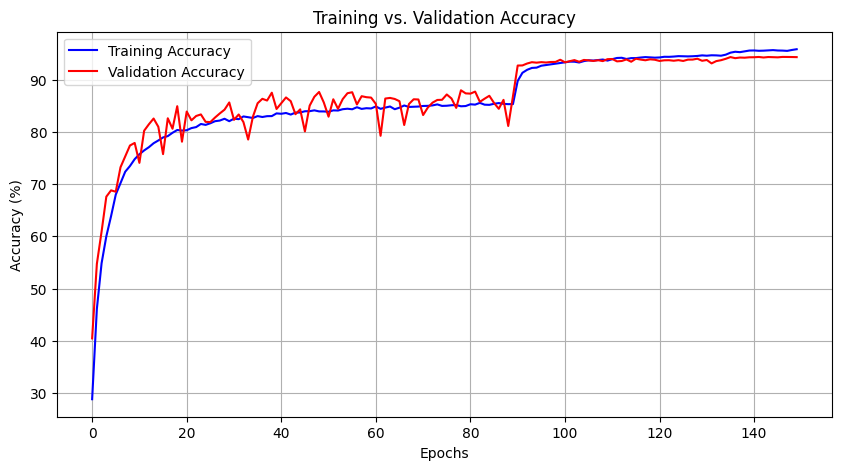

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, 'b-', label="Training Accuracy")
plt.plot(val_accuracies, 'r-', label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training vs. Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

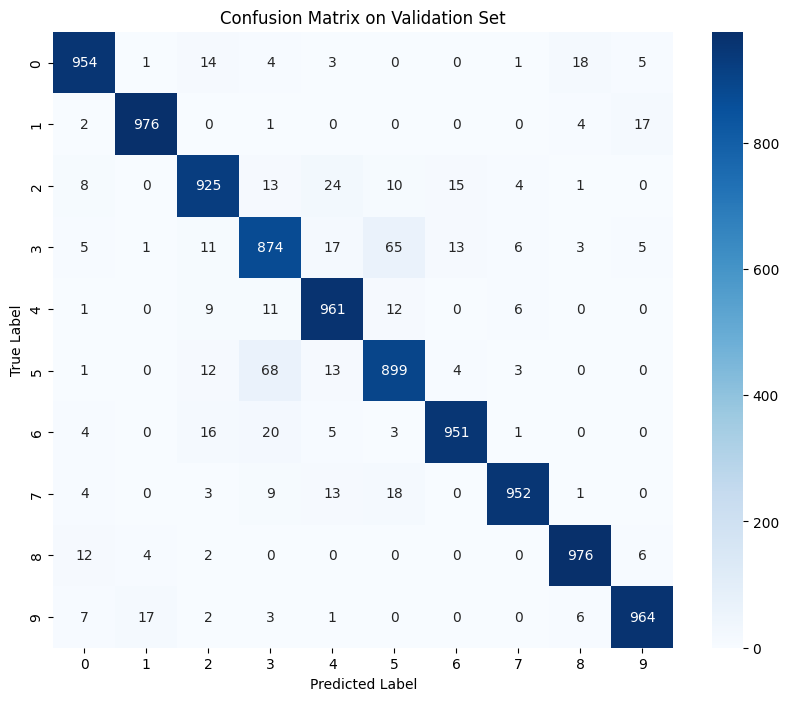

In [39]:
# Get true labels and predicted labels for validation set
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Validation Set")
plt.show()

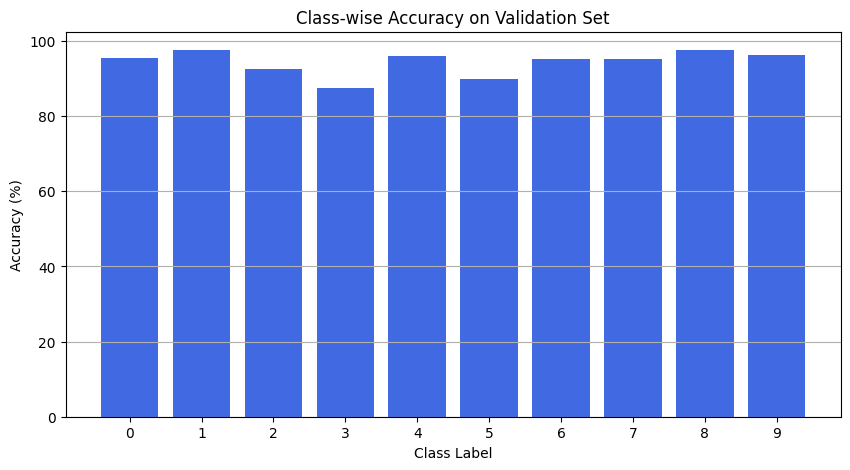

In [34]:
# Get accuracy per class
class_correct = Counter()
class_total = Counter()

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for label, pred in zip(labels.cpu().numpy(), preds.cpu().numpy()):
            class_correct[label] += (label == pred)
            class_total[label] += 1

# Compute class-wise accuracy
class_accuracies = {cls: 100 * (class_correct[cls] / class_total[cls]) for cls in class_total}

# Plot class-wise accuracy
plt.figure(figsize=(10, 5))
plt.bar(class_accuracies.keys(), class_accuracies.values(), color="royalblue")
plt.xlabel("Class Label")
plt.ylabel("Accuracy (%)")
plt.title("Class-wise Accuracy on Validation Set")
plt.xticks(range(10))
plt.grid(axis="y")
plt.show()

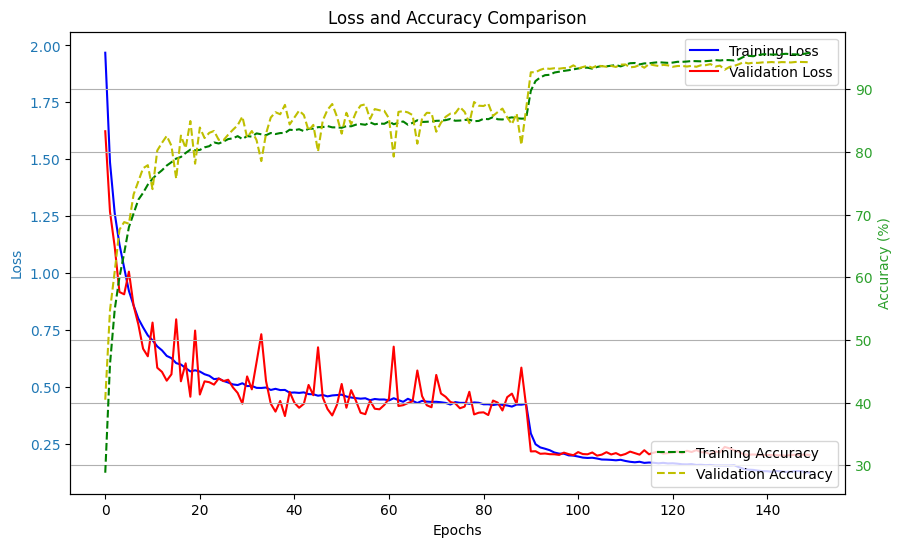

In [35]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss", color="tab:blue")
ax1.plot(train_losses, 'b-', label="Training Loss")
ax1.plot(val_losses, 'r-', label="Validation Loss")
ax1.tick_params(axis='y', labelcolor="tab:blue")
ax1.legend(loc="upper right")

ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy (%)", color="tab:green")
ax2.plot(train_accuracies, 'g--', label="Training Accuracy")
ax2.plot(val_accuracies, 'y--', label="Validation Accuracy")
ax2.tick_params(axis='y', labelcolor="tab:green")
ax2.legend(loc="lower right")

plt.title("Loss and Accuracy Comparison")
plt.grid(True)
plt.show()

In [36]:
torch.save(model.state_dict(), "project1_model.pt")
net = model

In [37]:
# Define the normalization (same as used during training)
normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))

def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    return batch

# Load test data (images and IDs)
test_batch = load_cifar_batch('/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl')

images_np = test_batch[b'data']  # shape (N, 32, 32, 3)
if b'ids' in test_batch:
    test_ids = test_batch[b'ids']
    # Convert to a numpy array of IDs if needed.
    test_ids = np.array(test_ids)
else:
    test_ids = np.arange(images_np.shape[0])

# Convert images to torch tensor, adjust shape to (N, 3, 32, 32) and normalize.
images_tensor = torch.from_numpy(images_np).permute(0, 3, 1, 2).float() / 255.0
images_tensor = normalize(images_tensor)

# Create a DataLoader for test data
test_dataset = TensorDataset(images_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Load label names (mapping of class indices to string labels)
meta_data_dict = load_cifar_batch(os.path.join('/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py', 'batches.meta'))
label_names = meta_data_dict[b'label_names']
label_names = [name.decode('utf-8') for name in label_names]

# Run inference on the test set
predictions = []

with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0].to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

# Map predicted class indices to their string labels
predicted_labels = [label_names[p] for p in predictions]

# Create a submission CSV file with columns "ID" and "Labels"
submission_df = pd.DataFrame({'ID': test_ids, 'Labels': predictions})
submission_df.to_csv('submission.csv', index=False)
print("Submission CSV saved as submission.csv")

Submission CSV saved as submission.csv
